**Bitcoin price prediction with Bayesian Neural Network Regression using torchBNN**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
import torchbnn as bnn

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
cwd = os.getcwd()
from os.path import dirname, abspath
while not cwd.endswith('BT4222_repo'):
    cwd = os.path.dirname(cwd)

In [3]:
# PATH = os.path.join(cwd , "data", "cooked_data", "cooked_complete_dataset.csv")
PATH ="cooked_complete_dataset.csv"

df = pd.read_csv(PATH,parse_dates =['date'])
df.dropna(inplace = True)
df.head()

,date,Adj_Close_BTC-USD,Open_BTC-USD,High_BTC-USD,Low_BTC-USD,Volume_BTC-USD,Adj_Close_SPY,Adj_Close_GLD,Adj_Close_CHFUSD=X,Adj_Close_CNYUSD=X,Adj_Close_EURUSD=X,Adj_Close_GBPUSD=X,Adj_Close_JPYUSD=X,coindesk_sentiment,num_of_coindesk_posts,reddit_comments_sentiments,top_50_reddit_posts_sentiments,blockchain_transactions_per_block,blockchain_hash_rates
0,2020-12-14,19246.64453,19144.49219,19305.09961,19012.70898,2.247400e+10,361.926788,171.539993,1.125442,0.152772,1.213340402,1.331824,0.009621,0.249489,12,0.188275,0.297238,2167.931034,134533587.6
1,2020-12-15,19417.07617,19246.91992,19525.00781,19079.84180,2.674198e+10,366.819824,173.940002,1.127930,0.152679,1.214889646,1.333084,0.009614,0.173773,18,0.144389,0.399427,2288.857143,133351912.2
2,2020-12-16,21310.59766,19418.81836,21458.90820,19298.31641,4.440901e+10,367.395508,174.899994,1.129382,0.152945,1.21543014,1.344447,0.009649,0.341491,11,0.137256,0.489673,2204.314685,132323572.3
3,2020-12-17,22805.16211,21308.35156,23642.66016,21234.67578,7.137861e+10,369.449982,176.740005,1.129446,0.153109,1.219958544,1.350293,0.009664,0.197572,10,0.156723,0.636030,2399.077519,132373208.7
4,2020-12-18,23137.96094,22806.79688,23238.60156,22399.81250,4.038790e+10,367.974792,176.440002,1.130301,0.153090,1.226271629,1.357018,0.009696,0.315601,2,0.166419,0.107093,2392.031847,131791042.0


**Helper Functions for creating lags and scaling**

In [4]:
def lag(data, dic):
    cols = []
    for key, value in dic.items():
        for i in range(1, value+1):
            cols.append(data[key].shift(i).rename('{}_lag{}'.format(data[key].name, i)))
    return pd.concat([data["date"],data["Adj_Close_BTC-USD"]] + cols, axis = 1)

scaler = StandardScaler()

def scale_and_convert_to_tensor(Xtrain, Xtest, Ytrain, Ytest, scaleTarget = False):  
    global scaler
    
    # Standardise features
    Xtrain_standardised = scaler.fit_transform(Xtrain)
    Xtest_standardised = scaler.transform(Xtest)
    
    # Standardise target
    Ytrain_standardised = Ytrain
    Ytest_standardised = Ytest
    
    if scaleTarget:    
        Ytrain_standardised = scaler.fit_transform(np.array(Ytrain).reshape(-1, 1))
        Ytest_standardised = scaler.transform(np.array(Ytest).reshape(-1, 1))
    
    ## Change to tensor
    Xtrain_tensor = torch.from_numpy(Xtrain_standardised).float()
    Ytrain_tensor = torch.from_numpy(np.array(Ytrain_standardised)).float()
    Xtest_tensor = torch.from_numpy(Xtest_standardised).float()
    Ytest_tensor = torch.from_numpy(np.array(Ytest_standardised)).float()
        
    return (Xtrain_tensor, Xtest_tensor, Ytrain_tensor, Ytest_tensor)

## Without Sentiments

**1. Create feature lags**

In [5]:
feature_lags = {"Adj_Close_BTC-USD" : 2, 
                'Open_BTC-USD': 1, 
                'Low_BTC-USD': 1, 
                'High_BTC-USD': 1, 
                "Volume_BTC-USD" : 1, 
                "Adj_Close_SPY" : 1,
                "Adj_Close_GLD" : 1,
                "Adj_Close_CHFUSD=X" : 1,
                "Adj_Close_CNYUSD=X" : 1,
                "Adj_Close_EURUSD=X" : 1,
                "Adj_Close_GBPUSD=X" : 1,
                "Adj_Close_JPYUSD=X" : 1,
                "blockchain_transactions_per_block" : 1,
                "blockchain_hash_rates" : 1}

data = lag(df, feature_lags)

**2. Handle train-test split**

In [6]:
data = data[data["date"] >= "1/1/2021"]

train = data[data["date"] <= "2021-03-10"]
test = data[data["date"] > "2021-03-10"]

X_train = train.drop(["date", "Adj_Close_BTC-USD"], axis = 1)
y_train = train["Adj_Close_BTC-USD"]

X_test = test.drop(["date", "Adj_Close_BTC-USD"], axis = 1)
y_test = test["Adj_Close_BTC-USD"]

**3. Standardise dataset and transform into tensors for pytorch**

In [7]:
## Standardise datasets and convert into tensors
Xtrain_tensor, Xtest_tensor, Ytrain_tensor, Ytest_tensor = scale_and_convert_to_tensor(X_train, X_test, y_train, y_test, scaleTarget = True)

print("X train tensor",Xtrain_tensor.shape)
print("Y train tensor",Ytrain_tensor.shape)
print("X test tensor",Xtest_tensor.shape)
print("Y test tensor",Ytest_tensor.shape)

X train tensor torch.Size([69, 15])
Y train tensor torch.Size([69, 1])
X test tensor torch.Size([21, 15])
Y test tensor torch.Size([21, 1])


**4. Define BNN training and evaluation pipeline**

In [50]:
def train_model_and_evaluate_regression(Xtrain_tensor, Ytrain_tensor, Xtest_tensor, Ytest_tensor, layers = [32,8], learning_param = 0.01, kl_weight = 0.01, steps = 100, printStep = True):    
    in_features = Xtrain_tensor.shape[1]
    batch_size = Xtrain_tensor.shape[0]
    
    ## Ensure reproducibility
    seed = 1
    torch.manual_seed(seed)
    
    # Build model
    layer = []
    
    ## Input layer
    layer.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features = in_features, out_features = layers[0]))
    layer.append(nn.ReLU())
    
    ## Hidden layers
    for index, neurons in enumerate(layers):
        if index != (len(layers)-1):
            layer.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=neurons, out_features=layers[index+1]))
            layer.append(nn.ReLU())

    ## Output layer
    layer.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=layers[-1], out_features=1))
    
    model = nn.Sequential(*layer)
    # Define Loss
    mse_loss = nn.MSELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)

    ## Define optimiser with learning rate
    optimizer = optim.Adam(model.parameters(), lr = learning_param)
    
    ### Train model
    for step in range(steps):
        torch.manual_seed(seed)
        
        pre = model(Xtrain_tensor)
        mse = mse_loss(pre, Ytrain_tensor)
        kl = kl_loss(model)
        cost = mse + kl_weight*kl

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        # Print Progress
        if step%50==0 and printStep:
            print('[Step %d]: MSE : %.8f, KL : %.8f' % (step , mse.item(), kl.item()))
            
    train_mse = mse.item()
    kl_loss = kl.item()
    
    ## Predict Test
    torch.manual_seed(seed)
    y_predict = model(Xtest_tensor)
    #y_predict_train = model(Xtrain_tensor)
    
    ## Performance Evaluation on test - MSE
    test_mse = mean_squared_error(Ytest_tensor.detach().numpy(),y_predict.detach().numpy())
    
    ## Inverse Standard Scaler - for unscaled RMSE 
    y_actual = scaler.inverse_transform(Ytest_tensor.detach().numpy().reshape(-1, 1))
    y_predict = scaler.inverse_transform(y_predict.detach().numpy().reshape(-1, 1))
    test_rmse = math.sqrt(mean_squared_error(y_actual,y_predict))
    
    #y_train_actual = scaler.inverse_transform(Ytrain_tensor.detach().numpy().reshape(-1, 1))
    #y_predict_train = scaler.inverse_transform(y_predict_train.detach().numpy().reshape(-1, 1))
    #train_rmse = math.sqrt(mean_squared_error(y_train_actual,y_predict_train))
    
    return (model ,y_predict, train_mse, test_mse, test_rmse,kl_loss)

**6. Perform Grid Search**

In [9]:
training_mse_list = []
testing_mse_list = []
testing_rmse_list = []
kl_list = []
combination = []

learning_param_list = pd.Series(np.linspace(0.001,0.5,50)).apply(lambda x: round(x,3))
kl_weight =  pd.Series(np.linspace(0.001,0.5,50)).apply(lambda x: round(x,3))
layers_list = ([32,16],[32,8],[32,16,8],[32,20,10])

for layer in layers_list:
    print("--- Layer: ", layer)
    for lr in learning_param_list:
        print("-- Learning Param: ", lr)
        for kl in kl_weight:
            combination.append("layer: {} lr: {} kl: {}".format(layer,lr,kl))
            _, _, train_mse, test_mse, test_rmse, train_rmse, kl_loss = train_model_and_evaluate_regression(Xtrain_tensor, Ytrain_tensor, Xtest_tensor, Ytest_tensor, layer, learning_param = lr, kl_weight = kl, steps = 100, printStep = False)
            training_mse_list.append(train_mse)
            testing_mse_list.append(test_mse)
            testing_rmse_list.append(test_rmse)
            kl_list.append(kl_loss)
            
print("Complete")

--- Layer:  [32, 16]
-- Learning Param:  0.001
-- Learning Param:  0.011
-- Learning Param:  0.021
-- Learning Param:  0.032
-- Learning Param:  0.042
-- Learning Param:  0.052
-- Learning Param:  0.062
-- Learning Param:  0.072
-- Learning Param:  0.082
-- Learning Param:  0.093
-- Learning Param:  0.103
-- Learning Param:  0.113
-- Learning Param:  0.123
-- Learning Param:  0.133
-- Learning Param:  0.144
-- Learning Param:  0.154
-- Learning Param:  0.164
-- Learning Param:  0.174
-- Learning Param:  0.184
-- Learning Param:  0.194
-- Learning Param:  0.205
-- Learning Param:  0.215
-- Learning Param:  0.225
-- Learning Param:  0.235
-- Learning Param:  0.245
-- Learning Param:  0.256
-- Learning Param:  0.266
-- Learning Param:  0.276
-- Learning Param:  0.286
-- Learning Param:  0.296
-- Learning Param:  0.307
-- Learning Param:  0.317
-- Learning Param:  0.327
-- Learning Param:  0.337
-- Learning Param:  0.347
-- Learning Param:  0.357
-- Learning Param:  0.368
-- Learning Param

In [10]:
results = pd.DataFrame({"Combination": combination,"Train MSE":training_mse_list, "Test MSE":testing_mse_list, "TEST RMSE":  testing_rmse_list,"KL Loss":kl_list})
results.to_csv("Combinations_regression_withoutSentiments&lagged2.csv")

## Find the hyperparameters with gives the lowest test RMSE
results[results['TEST RMSE'] ==  results['TEST RMSE'].min()]['Combination']

5176    layer: [32, 16, 8] lr: 0.032 kl: 0.266
Name: Combination, dtype: object

In [23]:
layer = [32, 16, 8]
lr = 0.032
kl = 0.266

model, y_predict, _, _, test_rmse, kl_loss = train_model_and_evaluate_regression(Xtrain_tensor, Ytrain_tensor, Xtest_tensor, Ytest_tensor, layer, learning_param = lr, kl_weight = kl, steps = 100, printStep = False)
print("Test RMSE: ",test_rmse)

Test RMSE:  1424.9727628975932


**7. Retrain the model with selected hyperparameters and all train data available**

In [24]:
### Helper function for retraining the model with all data available

def train_model_and_predict(Xtrain_tensor, Ytrain_tensor, layers = [32,8], learning_param = 0.01, kl_weight = 0.01, steps = 100):    
    """ 
    Trains model and returns predictions on entire dataset.
    """
    in_features = Xtrain_tensor.shape[1]
    batch_size = Xtrain_tensor.shape[0]
    
    ## Ensure reproducibility
    seed = 1
    torch.manual_seed(seed)
    
    # Build model
    layer = []
    
    ## Input layer
    layer.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features = in_features, out_features = layers[0]))
    layer.append(nn.ReLU())
    
    ## Hidden layers
    for index, neurons in enumerate(layers):
        if index != (len(layers)-1):
            layer.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=neurons, out_features=layers[index+1]))
            layer.append(nn.ReLU())

    ## Output layer
    layer.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=layers[-1], out_features=1))
    
    model = nn.Sequential(*layer)
    # Define Loss
    mse_loss = nn.MSELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)

    ## Define optimiser with learning rate
    optimizer = optim.Adam(model.parameters(), lr = learning_param)
    
    ### Train model
    for step in range(steps):
        torch.manual_seed(seed)
        
        pre = model(Xtrain_tensor)
        mse = mse_loss(pre, Ytrain_tensor)
        kl = kl_loss(model)
        cost = mse + kl_weight*kl

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
    ## Predict Test
    torch.manual_seed(seed)
    y_predict = model(Xtrain_tensor)

    ## Inverse Standard Scaler
    y_predict = scaler.inverse_transform(y_predict.detach().numpy().reshape(-1, 1))
    
    return (model,y_predict)

In [25]:
### Obtain all available data
x_refit = data.drop(["date", "Adj_Close_BTC-USD"], axis = 1)
y_refit = data["Adj_Close_BTC-USD"]

### Used helper standardise function to create test and train but Xtrain_tensor is equal to Xtest_tensor
Xtrain_tensor, Xtest_tensor, Ytrain_tensor, Ytest_tensor = scale_and_convert_to_tensor(x_refit, x_refit, y_refit, y_refit, scaleTarget = True)


In [26]:
model, y_predict = train_model_and_predict(Xtrain_tensor, Ytrain_tensor, layers = [32, 16, 8], learning_param = 0.032, kl_weight = 0.266, steps = 100)        

**8. Backtesting**

In [28]:
import sys 
sys.path.append(os.path.abspath(cwd))
from backtesting.backtest import *

In [29]:
returns_without_adj = backtest_regression_noSentiment(list(y_predict.flatten()), 
                                                      data.date.tolist(), 
                                                      "BNN_regression_no_sentiment_without_adj")

In [30]:
# weighted sentiments
sentiments = df[df["date"].isin(data.date)]
sentiments = sentiments["reddit_comments_sentiments"] + sentiments["top_50_reddit_posts_sentiments"]
sentiments = ["positive" if x > np.mean(sentiments) else "negative" for x in sentiments]

returns_with_adj = backtest_regression_WithSentiment(list(y_predict.flatten()), 
                                  data.date.tolist(), 
                                  sentiments, "BNN_regression_no_sentiment_with_adj")

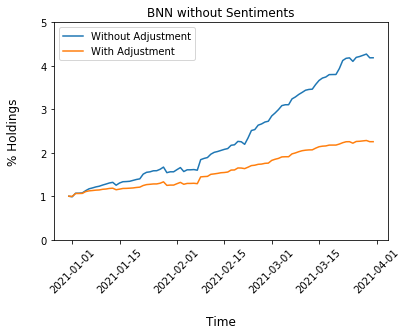

In [31]:
datePlot = [data.date.tolist()[0]- timedelta(days=1),] + data.date.tolist()
plotHoldings_without_adj = pd.Series(returns_without_adj, index = datePlot)
plotHoldings_with_adj = pd.Series(returns_with_adj, index = datePlot)

plt.plot(plotHoldings_without_adj, label = "Without Adjustment")
plt.plot(plotHoldings_with_adj, label = "With Adjustment")
plt.xticks(rotation = 45)
plt.ylim(bottom = 0, top = 5)
plt.ylabel("% Holdings", labelpad = 20, fontsize = 12)
plt.xlabel("Time", labelpad = 20, fontsize = 12)
plt.title("BNN without Sentiments")
plt.legend()
plt.show()

## With Sentiments

**1. Create Feature Lags**

In [45]:
feature_lags = {"Adj_Close_BTC-USD" : 2, 
                'Open_BTC-USD': 1, 
                'Low_BTC-USD': 1, 
                'High_BTC-USD': 1, 
                "Volume_BTC-USD" : 1, 
                "Adj_Close_SPY" : 1,
                "Adj_Close_GLD" : 1,
                "Adj_Close_CHFUSD=X" : 1,
                "Adj_Close_CNYUSD=X" : 1,
                "Adj_Close_EURUSD=X" : 1,
                "Adj_Close_GBPUSD=X" : 1,
                "Adj_Close_JPYUSD=X" : 1,
                "blockchain_transactions_per_block" : 1,
                "blockchain_hash_rates" : 1,
                "coindesk_sentiment" : 1,
                "num_of_coindesk_posts" : 1,
                "reddit_comments_sentiments" : 1,
                "top_50_reddit_posts_sentiments" : 1}

data = lag(df, feature_lags)

**2. Handle Train-test split**

In [46]:
data = data[data["date"] >= "1/1/2021"]

train = data[data["date"] <= "2021-03-10"]
test = data[data["date"] > "2021-03-10"]

X_train = train.drop(["date", "Adj_Close_BTC-USD"], axis = 1)
y_train = train["Adj_Close_BTC-USD"]

X_test = test.drop(["date", "Adj_Close_BTC-USD"], axis = 1)
y_test = test["Adj_Close_BTC-USD"]

**3. Standardise dataset and transform to tensors** 

In [47]:
## Standardise datasets and convert into tensors
Xtrain_tensor, Xtest_tensor, Ytrain_tensor, Ytest_tensor = scale_and_convert_to_tensor(X_train, X_test, y_train, y_test, scaleTarget = True)

print("X train tensor",Xtrain_tensor.shape)
print("Y train tensor",Ytrain_tensor.shape)
print("X test tensor",Xtest_tensor.shape)
print("Y test tensor",Ytest_tensor.shape)

X train tensor torch.Size([69, 19])
Y train tensor torch.Size([69, 1])
X test tensor torch.Size([21, 19])
Y test tensor torch.Size([21, 1])


**4. Perform GridSearch**

In [258]:
### Hyperparameter Tuning --> find best parameters
training_mse_list = []
testing_mse_list = []
testing_rmse_list = []
kl_list = []
combination = []

learning_param_list = pd.Series(np.linspace(0.001,0.5,50)).apply(lambda x: round(x,3))
kl_weight =  pd.Series(np.linspace(0.001,0.5,50)).apply(lambda x: round(x,3))
layers_list = ([32,16],[32,8],[32,16,8],[32,20,10])

for layer in layers_list:
    print("--- Layer: ", layer)
    for lr in learning_param_list:
        print("-- Learning Param: ", lr)
        for kl in kl_weight:
            combination.append("layer: {} lr: {} kl: {}".format(layer,lr,kl))
            _, _, train_mse, test_mse, test_rmse, kl_loss = train_model_and_evaluate_regression(Xtrain_tensor, Ytrain_tensor, Xtest_tensor, Ytest_tensor, layer, learning_param = lr, kl_weight = kl, steps = 100, printStep = False)
            training_mse_list.append(train_mse)
            testing_mse_list.append(test_mse)
            testing_rmse_list.append(test_rmse)
            kl_list.append(kl_loss)
            
print("Complete")

--- Layer:  [32, 16]
-- Learning Param:  0.001
-- Learning Param:  0.011
-- Learning Param:  0.021
-- Learning Param:  0.032
-- Learning Param:  0.042
-- Learning Param:  0.052
-- Learning Param:  0.062
-- Learning Param:  0.072
-- Learning Param:  0.082
-- Learning Param:  0.093
-- Learning Param:  0.103
-- Learning Param:  0.113
-- Learning Param:  0.123
-- Learning Param:  0.133
-- Learning Param:  0.144
-- Learning Param:  0.154
-- Learning Param:  0.164
-- Learning Param:  0.174
-- Learning Param:  0.184
-- Learning Param:  0.194
-- Learning Param:  0.205
-- Learning Param:  0.215
-- Learning Param:  0.225
-- Learning Param:  0.235
-- Learning Param:  0.245
-- Learning Param:  0.256
-- Learning Param:  0.266
-- Learning Param:  0.276
-- Learning Param:  0.286
-- Learning Param:  0.296
-- Learning Param:  0.307
-- Learning Param:  0.317
-- Learning Param:  0.327
-- Learning Param:  0.337
-- Learning Param:  0.347
-- Learning Param:  0.357
-- Learning Param:  0.368
-- Learning Param

In [49]:
results_withSentiments = pd.DataFrame({"Combination": combination,"Train MSE":training_mse_list, "Test MSE":testing_mse_list, "TEST RMSE":  testing_rmse_list,"KL Loss":kl_list})
results_withSentiments.to_csv("Combinations_regression_withSentiments&lagged2.csv")

## Find the parameters with gives the lowest test RMSE
results_withSentiments[results_withSentiments['TEST RMSE'] ==  results_withSentiments['TEST RMSE'].min()]['Combination']

387    layer: [32, 16] lr: 0.072 kl: 0.378
Name: Combination, dtype: object

In [51]:
layer = [32, 16]
lr = 0.072
kl = 0.378

model, y_predict, _, _, test_rmse, kl_loss = train_model_and_evaluate_regression(Xtrain_tensor, Ytrain_tensor, Xtest_tensor, Ytest_tensor, layer, learning_param = lr, kl_weight = kl, steps = 100, printStep = False)
print("Test RMSE: ", test_rmse)

Test RMSE:  1787.7710284038053


**5. Retrain the model with selected hyperparameters and all data available.**

In [52]:
### Obtain all available data
x_refit = data.drop(["date", "Adj_Close_BTC-USD"], axis = 1)
y_refit = data["Adj_Close_BTC-USD"]

### Used helper standardise function to create test and train but Xtrain_tensor is equal to Xtest_tensor
Xtrain_tensor, Xtest_tensor, Ytrain_tensor, Ytest_tensor = scale_and_convert_to_tensor(x_refit, x_refit, y_refit, y_refit, scaleTarget = True)

In [53]:
model, y_predict = train_model_and_predict(Xtrain_tensor, Ytrain_tensor, layers = [32, 16, 8], learning_param = 0.032, kl_weight = 0.266, steps = 100)        

In [54]:
pd.DataFrame(y_predict.flatten()).to_csv("out.csv")

In [55]:
returns_without_adj = backtest_regression_noSentiment(list(y_predict.flatten()), 
                                                      data.date.tolist(), 
                                                      "BNN_regression_with_sentiment_without_adj")

In [56]:
# weighted sentiments
returns_with_adj = backtest_regression_WithSentiment(list(y_predict.flatten()), 
                                  data.date.tolist(), 
                                  sentiments, "BNN_regression_with_sentiment_with_adj")

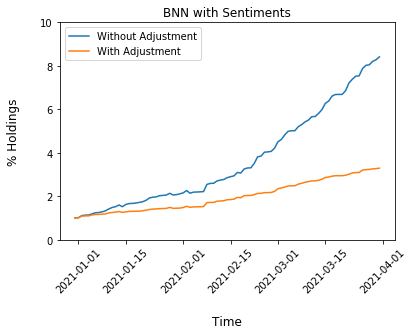

In [57]:
datePlot = [data.date.tolist()[0]- timedelta(days=1),] + data.date.tolist()
plotHoldings_without_adj = pd.Series(returns_without_adj, index = datePlot)
plotHoldings_with_adj = pd.Series(returns_with_adj, index = datePlot)

plt.plot(plotHoldings_without_adj, label = "Without Adjustment")
plt.plot(plotHoldings_with_adj, label = "With Adjustment")
plt.xticks(rotation = 45)
plt.ylim(bottom = 0, top = 10)
plt.ylabel("% Holdings", labelpad = 20, fontsize = 12)
plt.xlabel("Time", labelpad = 20, fontsize = 12)
plt.title("BNN with Sentiments")
plt.legend()
plt.show()